In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!ls "/content/drive/MyDrive/DeepLearning/Common Literacy"

Common_Literacy_AVGW2V_POS.ipynb
Common_Literacy_AVGW2V_TFIDFAVGW2V_POS.ipynb
CommonLiteracyBertModels.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D.ipynb
Common_Literacy_BOW_TFIDF_AvgW2V100D_SVD.ipynb
Common_Literacy_BOW_TFIDF_AVGW2V300D.ipynb
CommonLiteracy_CNN_Model.ipynb
Dataset


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from mlxtend.regressor import StackingRegressor

# Gensim Models word2vec
import gensim
from gensim.models import Word2Vec
%matplotlib inline

In [4]:
train ='/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/train.csv'
test = '/content/drive/MyDrive/DeepLearning/Common Literacy/Dataset/test.csv'

In [5]:
df_train = pd.read_csv(train)
df_test = pd.read_csv(test)

In [6]:
print("This is train dataset")
print(df_train.head(2))
print(df_train.columns)
print("="*100)
print("This is test dataset")
print(df_test.head(2))
print(df_test.columns)

This is train dataset
          id url_legal  ...    target standard_error
0  c12129c31       NaN  ... -0.340259       0.464009
1  85aa80a4c       NaN  ... -0.315372       0.480805

[2 rows x 6 columns]
Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error'], dtype='object')
This is test dataset
          id  ...                                            excerpt
0  c0f722661  ...  My hope lay in Jack's promise that he would ke...
1  f0953f0a5  ...  Dotty continued to go to Mrs. Gray's every nig...

[2 rows x 4 columns]
Index(['id', 'url_legal', 'license', 'excerpt'], dtype='object')


Text(0, 0.5, 'Probability Density')

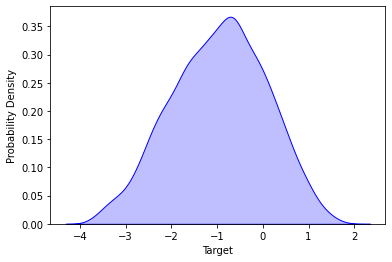

In [7]:
# plotting the KDE plot fot check the distribution of the dependents
import seaborn as sns

sns.kdeplot(df_train['target'], color='b', shade=True, Label='Target')
# Setting the X and Y Label
plt.xlabel('Target')
plt.ylabel('Probability Density')

In [8]:
# importing stopwords from nltk library
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stopword = stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over',

### Pretrained Glove Vector assignment

In [9]:
# Refer this for step by step method https://stackoverflow.com/questions/50060241/how-to-use-glove-word-embeddings-file-on-google-colaboratory

!wget http://nlp.stanford.edu/data/glove.6B.zip # get the glove vector from stanford library

--2021-07-13 10:23:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-13 10:23:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-13 10:23:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [51]:
!wget http://www.cs.cmu.edu/~bmurphy/NNSE/depDocNNSE300.tab.zip

--2021-07-13 13:32:14--  http://www.cs.cmu.edu/~bmurphy/NNSE/depDocNNSE300.tab.zip
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9562895 (9.1M) [application/zip]
Saving to: ‘depDocNNSE300.tab.zip’

depDocNNSE300.tab.z 100%[===================>]   9.12M  1.32MB/s    in 8.7s    

2021-07-13 13:32:23 (1.05 MB/s) - ‘depDocNNSE300.tab.zip’ saved [9562895/9562895]



In [52]:
!unzip dep*.zip

Archive:  depDocNNSE300.tab.zip
  inflating: depDocNNSE300.tab       


In [66]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

d_model = 300
nnse_dict = {}
f = open('depDocNNSE300.tab', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    nnse_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(nnse_dict))

Indexing word vectors.
Found 35364 word vectors.


In [61]:
# creating a set of the keys from glove dictionary
nnse_words = set(nnse_dict.keys())

In [62]:
# code to check for 3 dictionary values in text.
import itertools
# Initialize limit 
N = 3
    
# Using islice() + items() 
# Get first N items in dictionary 
out = dict(itertools.islice(nnse_dict.items(), N)) 

# printing result  
print("Dictionary limited by K is : " + str(out))

Dictionary limited by K is : {'1': array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1

In [10]:
#unzip the downloaded glove vectors to drive
!unzip glove*.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.50d.txt        
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: glove.6B.100d.txt       y

replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.200d.txt       y

replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: glove.6B.300d.txt       y



In [11]:
# creating the dictionary if word and vectors
print('Indexing word vectors.')

d_model = 100
glove_dict = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_dict[word] = coefs
f.close()

print('Found %s word vectors.' % len(glove_dict))

# checking the dictionary word shape
print(glove_dict['the'].shape)

Indexing word vectors.
Found 400000 word vectors.
(100,)


In [12]:
# creating a set of the keys from glove dictionary
glove_words = set(glove_dict.keys())

In [13]:
# # code to check for 3 dictionary values in text.
# import itertools
# # Initialize limit 
# N = 3
    
# # Using islice() + items() 
# # Get first N items in dictionary 
# out = dict(itertools.islice(glove_50d.items(), N)) 

# # printing result  
# print("Dictionary limited by K is : " + str(out))

### Cleaning the text data for any special characters and numerical characters

In [14]:
def testpreprocess(phrase):
    phrase = re.sub('[^A-Za-z0-9]+', ' ', phrase)
    phrase = re.sub(r'\w*\d\w*', '', phrase).strip()
    return phrase

In [15]:
preprocessed_excerpt = []
for sentence in tqdm(df_train['excerpt'].values):
  sent = testpreprocess(sentence)
  sent = sent.lower().strip()
  sent = ' '.join(e for e in sent.split(" ") if e not in stopword)
  preprocessed_excerpt.append(sent)

df_train['cleaned_excerpt'] = preprocessed_excerpt

100%|██████████| 2834/2834 [00:01<00:00, 1731.77it/s]


In [16]:
print(df_train['excerpt'].values[0])
print("="*100)
print(df_train['cleaned_excerpt'].values[0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.
young p

In [17]:
print(df_train.columns)

Index(['id', 'url_legal', 'license', 'excerpt', 'target', 'standard_error',
       'cleaned_excerpt'],
      dtype='object')


### Glove Average Word 2 Vec Model

In [18]:
# Function to calculate the average word to vec for each sentence paragraph in the series
def Avg_W2V(selfie): # give a pandas series into
  # compute average word2vec for each review.
  AvgW2V_list = []; # the avg-w2v for each sentence/review is stored in this list
  for sentence in tqdm(selfie.values): # for each review/sentence
      vector = np.zeros(d_model) # as word vectors are of zero length
      cnt_words =0; # num of words with a valid vector in the sentence/review
      for word in sentence.split(): # for each word in a review/sentence
          if word in glove_words: # this is set of glove vector keys
              vector += glove_dict[word] # this is adding the vector of 100 dimensions
              cnt_words += 1
      if cnt_words != 0:
          vector /= cnt_words
      AvgW2V_list.append(vector)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Glove Average Word 2 Vec With Positional Encoding

In [19]:
def positionalEncoding2d(max_sentence_length,d_model):
  positional_embeddings = np.zeros((max_sentence_length, d_model))
  for position in range(max_sentence_length):
      for i in range(0, d_model, 2):
        positional_embeddings[position, i] = (np.sin(position/(10000 ** ((2*i) / d_model))))
        positional_embeddings[position, i + 1] = (np.cos(position/(10000 ** ((2*(i+1)) / d_model))))
  return positional_embeddings

def Avg_W2V_Pos(selfie): # give a pandas series into
  array_col_size = selfie.size
  AvgW2V_list = []; 
  for sentence in tqdm(selfie.values): 
      sentence = sentence.split()
      max_sentence_length = len(sentence)
      empty_vector = np.empty((0,d_model),dtype=float)
      posEmbed = positionalEncoding2d(max_sentence_length,d_model)
      for word in sentence:
          if (word in glove_words): 
            vector =  glove_dict[word] 
            vectorTranspose = np.reshape(vector,(-1,d_model))
            empty_vector = np.append(empty_vector,vectorTranspose,axis=0)
          else:
            vectorZeros = np.zeros((1,d_model),dtype=float)
            empty_vector = np.append(empty_vector,vectorZeros,axis=0)
      WordEmbedPOS = np.add(posEmbed, empty_vector)
      WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
      WordEmbedPOSColSum /= max_sentence_length
      AvgW2V_list.append(WordEmbedPOSColSum)
  AvgW2V_Array = np.stack(AvgW2V_list, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return AvgW2V_Array

### Global TF-IDF Avg Word 2 Vec with Positional Embedding

In [20]:
def Tfidf_Avg_W2V_Pos(selfie):
  tfidf_model = TfidfVectorizer()
  tfidf_model.fit(selfie)
  # we are converting a dictionary with word as a key, and the idf as a value
  dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
  tfidf_words = set(tfidf_model.get_feature_names())

  tfidf_w2v_vectors = []
  for sentence in tqdm(selfie.values): 
    sentence = sentence.split()
    max_sentence_length = len(sentence)
    empty_vector = np.empty((0,d_model),dtype=float)
    posEmbed = positionalEncoding2d(max_sentence_length,d_model)
    tf_idf_weight = 0
    for word in sentence:
      if (word in glove_words) and (word in tfidf_words):
        vector = glove_dict[word]
        tf_idf = dictionary[word]*(sentence.count(word)/len(sentence)) # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
        vector_Tfidf = (vector * tf_idf) # calculating tfidf weighted w2v
        vectorTranspose = np.reshape(vector_Tfidf,(-1,d_model))
        empty_vector = np.append(empty_vector,vectorTranspose,axis=0)
      else:
        vectorZeros = np.zeros((1,d_model),dtype=float)
        empty_vector = np.append(empty_vector,vectorZeros,axis=0)
    WordEmbedPOS = np.add(posEmbed, empty_vector)
    WordEmbedPOSColSum  = WordEmbedPOS.sum(axis=0)
    WordEmbedPOSColSum /= max_sentence_length
    tfidf_w2v_vectors.append(WordEmbedPOSColSum)
  tfidf_w2v_vectors_Array = np.stack(tfidf_w2v_vectors, axis=0) # used to flatten the vector to one axis and convert the list of list to array
  return tfidf_w2v_vectors_Array


### Splitting data into Train and cross validation(or test): Stratified Sampling

In [21]:
Y = df_train['target']
X = df_train['cleaned_excerpt']

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

In [23]:
print(X_train.head(5))

1106    jacob lived land father stayed land canaan acc...
1334    bulgarian government left prejudices one side ...
1551    looked clock quarter twelve could visitor late...
1389    grumbling lot kept wondering folks much money ...
2216    ludwig four years old began study music like c...
Name: cleaned_excerpt, dtype: object


### TF-IDF processing of text

In [24]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_tfidf = vectorizer.transform(X_train)
X_test_excerpt_tfidf = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf.shape, Y_train.shape)
print(X_test_excerpt_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 4897) (1898,)
(936, 4897) (936,)


### Bag of Words 

In [25]:
vectorizer = CountVectorizer(ngram_range=(1, 1),min_df=5)
vectorizer.fit(X_train)
feature_names = vectorizer.get_feature_names()

X_train_excerpt_bow = vectorizer.transform(X_train)
X_test_excerpt_bow = vectorizer.transform(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_bow.shape, Y_train.shape)
print(X_test_excerpt_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(1898, 4897) (1898,)
(936, 4897) (936,)


### Average Word 2 Vec

In [26]:
X_train_excerpt_avg_w2v = Avg_W2V(X_train)
X_test_excerpt_avg_w2v = Avg_W2V(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:00<00:00, 4253.75it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


### Average Word 2 Vec with Positional Embedding

In [27]:
X_train_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_train)
X_test_excerpt_avg_w2v_pos = Avg_W2V_Pos(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_avg_w2v_pos.shape, Y_train.shape)
print(X_test_excerpt_avg_w2v_pos.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:14<00:00, 66.73it/s]

After vectorizations
(1898, 100) (1898,)
(936, 100) (936,)


### TFIDF - Average Word 2 Vec with Positional Embedding

In [28]:
X_train_excerpt_tfidf_avg_w2v_pos = Tfidf_Avg_W2V_Pos(X_train)
X_test_excerpt_tfidf_avg_w2v_pos = Tfidf_Avg_W2V_Pos(X_test)

print("="*100)
print("After vectorizations")
print("="*50)
print(X_train_excerpt_tfidf_avg_w2v_pos.shape, Y_train.shape)
print(X_train_excerpt_tfidf_avg_w2v_pos.shape, Y_test.shape)
print("="*100)

100%|██████████| 936/936 [00:14<00:00, 64.34it/s]

After vectorizations
(1898, 100) (1898,)
(1898, 100) (936,)


## Truncated SVD Implementation

### Truncated SVD for TF-IDF

In [29]:
# # Program to find the optimal number of components for Truncated SVD
# n_comp = [500,700,800,900,1000,1500,2000,2500,3000,3500,4000] # list containing different values of components
# explained = [] # explained variance ratio for each component of Truncated SVD
# for x in n_comp:
#     svd = TruncatedSVD(n_components=x,n_iter=20)
#     svd.fit(X_train_excerpt_tfidf)
#     explained.append(svd.explained_variance_ratio_.sum())
#     print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
# plt.plot(n_comp, explained)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [30]:
# best_SVD_tfidf = TruncatedSVD(n_components=2000,n_iter=20)
# best_SVD_tfidf.fit(X_train_excerpt_tfidf)

# X_train_excerpt_tfidf_svd = best_SVD_tfidf.transform(X_train_excerpt_tfidf)
# X_test_excerpt_tfidf_svd = best_SVD_tfidf.transform(X_test_excerpt_tfidf)

### Truncated SVD for Avg Word2Vec

In [31]:
# # Program to find the optimal number of components for Truncated SVD
# n_comp = [4,10,15,20,30,40,50,60,70,80,90,95,100,150,200,250,299] # list containing different values of components
# explained = [] # explained variance ratio for each component of Truncated SVD
# for x in n_comp:
#     svd = TruncatedSVD(n_components=x)
#     svd.fit(X_train_excerpt_avgw2v)
#     explained.append(svd.explained_variance_ratio_.sum())
#     print("Number of components = %r and explained variance = %r"%(x,svd.explained_variance_ratio_.sum()))
# plt.plot(n_comp, explained)
# plt.xlabel('Number of components')
# plt.ylabel("Explained Variance")
# plt.title("Plot of Number of components v/s explained variance")
# plt.show()

In [32]:
# best_SVD_w2v = TruncatedSVD(n_components=150,n_iter=20)
# best_SVD_w2v.fit(X_train_excerpt_avgw2v)

# X_train_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_train_excerpt_avgw2v)
# X_test_excerpt_avgw2v_svd = best_SVD_w2v.transform(X_test_excerpt_avgw2v)

# Various Models

### Linear Regression

In [33]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_tfidf, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_tfidf,Y_train)

Y_pred = lr.predict(X_test_excerpt_tfidf)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.26113601 0.27804612 0.35769378 0.30724486 0.33449263] 0.3077226785076042 0.03539770058610237
This is root mean square error:  0.917542116820548


In [34]:
lr = LinearRegression()
scores = cross_val_score(lr, X_train_excerpt_bow, Y_train, cv = 5)
print(scores,np.mean(scores),np.std(scores))
lr.fit(X_train_excerpt_bow,Y_train)

Y_pred = lr.predict(X_test_excerpt_bow)

mse = metrics.mean_squared_error(Y_test,Y_pred)
print("This is root mean square error: ", np.sqrt(mse))

[0.15694469 0.11370417 0.22129046 0.1984625  0.17145423] 0.17237120848821225 0.036754560158579336
This is root mean square error:  0.9924274206971373


In [35]:
# data = {"Bag of Words":(X_train_excerpt_bow,X_test_excerpt_bow),"TF-IDF":(X_train_excerpt_tfidf,X_test_excerpt_tfidf),"Avg Word2Vec":(X_train_excerpt_avgw2v,X_test_excerpt_avgw2v)}
data = {"Avg Word2Vec Pos":(X_train_excerpt_avg_w2v_pos,X_test_excerpt_avg_w2v_pos),"TFIDF - Avg Word2Vec Pos":(X_train_excerpt_tfidf_avg_w2v_pos,X_test_excerpt_tfidf_avg_w2v_pos)}

### Function to run all models together

In [36]:
def modelfunction(modelname,data,Y_train,Y_test,param):
  for key,value in tqdm(data.items()):
    train = value[0]
    test = value[1]
    gscv = GridSearchCV(modelname, param_grid=param,cv=5,verbose=10,n_jobs=-1)
    results = gscv.fit(train, Y_train)
    best_estimate = gscv.best_estimator_

    Y_pred_train = best_estimate.predict(train)
    train_residuals = Y_train - Y_pred_train
    Y_pred_test = best_estimate.predict(test)
    test_residuals = Y_test - Y_pred_test
    mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
    mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

    print("-"*100)
    print("The model is run on {}: ".format(key))
    print("="*100)
    print(best_estimate)
    print("*"*50)
    print("Root Mean squared Error Train for {}: ".format(key), np.sqrt(mse_train))
    print("Root Mean squared Error Test for {}: ".format(key), np.sqrt(mse_test))

    plt.subplot(1,2,1)
    plt.scatter(train_residuals.index,train_residuals)
    plt.title("Train Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')

    plt.subplot(1,2,2)
    plt.scatter(test_residuals.index,test_residuals)
    plt.title("Test Error Plot")
    plt.xlabel('Index')
    plt.ylabel('Actual - Predicted')
    plt.show()

### Lasso Regression

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1810s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0309s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.8s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6602252158317294
Root Mean squared Error Test for Avg Word2Vec Pos:  0.67425527548985


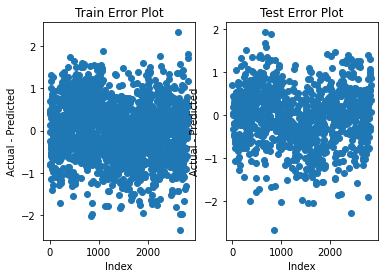

 50%|█████     | 1/2 [00:02<00:02,  2.24s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1819s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0677s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0521s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    0.8s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.8112167533988075
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.8527514712904


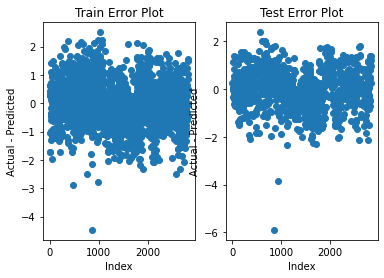

100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


In [37]:
lasso_params = {'alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1]}
lasso = Lasso()

modelfunction(lasso,data,Y_train,Y_test,lasso_params)

### Ridge Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0302s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0359s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0518s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6531481450259021
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6737856020902868


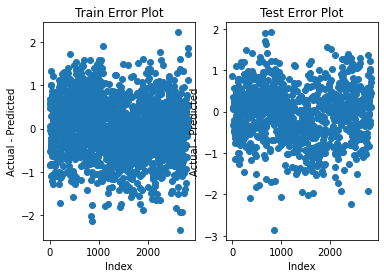

 50%|█████     | 1/2 [00:00<00:00,  1.68it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0143s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0382s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0574s.) Setting batch_size=8.


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.8198707181756018
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.8540357739368927


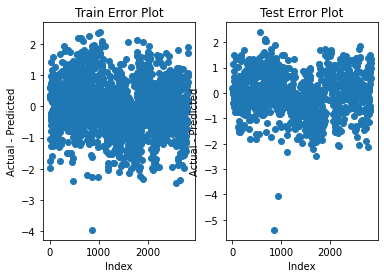

100%|██████████| 2/2 [00:01<00:00,  1.51it/s]


In [38]:
ridge_params = {'alpha':[0.00001,0.0001,0.001,0.01,0.1,1.0]}
ridge = Ridge()

modelfunction(ridge,data,Y_train,Y_test,ridge_params)

### SGD Regressor

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0879s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.1844s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.4s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SGDRegressor(alpha=1e-06, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.7011330913865963
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6921841211300183


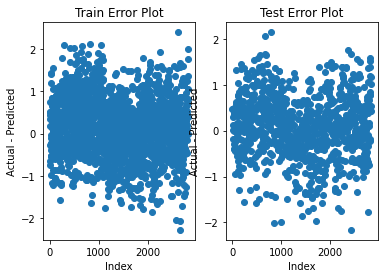

 50%|█████     | 1/2 [00:02<00:02,  2.92s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0979s.) Setting batch_size=2.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1830s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1345s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.8s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
SGDRegressor(alpha=1e-07, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.9420064847102992
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.9423285652651121


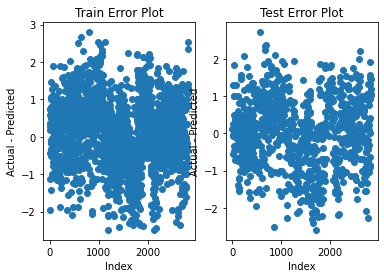

100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


In [39]:
SGD_params = {'alpha':[0.0000001,0.000001,0.00001,0.0001,0.001,0.01,0.1,0.2,0.3],'penalty':['l1','l2']}
SGD = SGDRegressor()

modelfunction(SGD,data,Y_train,Y_test,SGD_params)

### KNN Regression

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    5.9s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.701882677362602
Root Mean squared Error Test for Avg Word2Vec Pos:  0.742884600344629


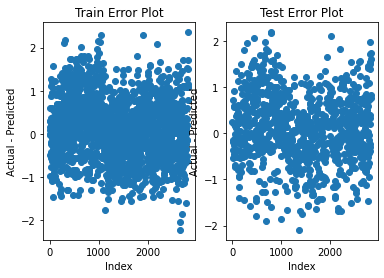

 50%|█████     | 1/2 [00:07<00:07,  7.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1349s.) Setting batch_size=2.


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    4.0s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                    weights='uniform')
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.7941561010124587
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.8515145232371131


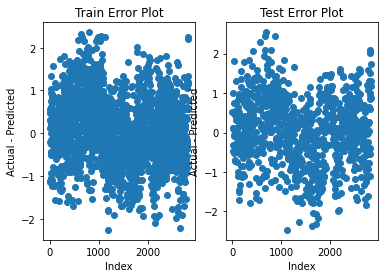

100%|██████████| 2/2 [00:12<00:00,  6.22s/it]


In [40]:
KNN_params = {'n_neighbors':[7,8,10,15,20,30,40,50,80,90,100],'algorithm':['kd_tree']}
KNN = KNeighborsRegressor()

modelfunction(KNN,data,Y_train,Y_test,KNN_params)

### Linear SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0116s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Batch computation too slow (2.4533s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   28.8s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6610540364210574
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6840565218845633


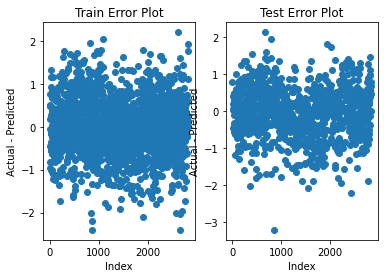

 50%|█████     | 1/2 [00:30<00:30, 31.00s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0109s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Batch computation too slow (2.0960s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.8124071441124171
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.86654456984636


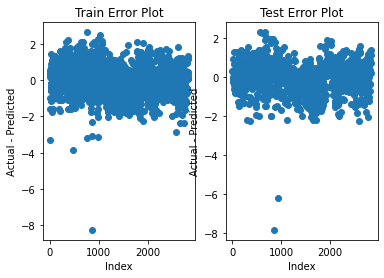

100%|██████████| 2/2 [00:40<00:00, 20.39s/it]


In [41]:
SVR_params = {'C':range(0,30,5)}
LinearSVR = SVR(kernel='linear')

modelfunction(LinearSVR,data,Y_train,Y_test,SVR_params)

### RBF SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.3min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.49337026873675466
Root Mean squared Error Test for Avg Word2Vec Pos:  0.647367836293768


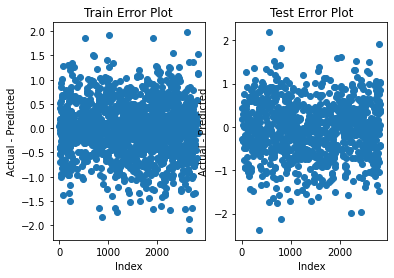

 50%|█████     | 1/2 [01:22<01:22, 82.91s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   19.1s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
SVR(C=300, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.7378119633748748
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.7989883823270979


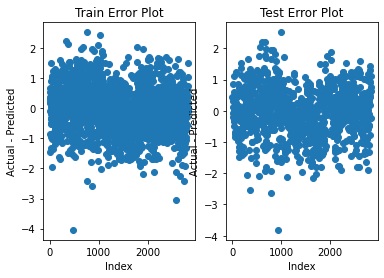

100%|██████████| 2/2 [01:44<00:00, 52.05s/it]


In [42]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
RBF_SVR = SVR(kernel='rbf',gamma="scale")

modelfunction(RBF_SVR,data,Y_train,Y_test,SVR_params)

### Poly SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   23.3s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=500, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.5754502065513692
Root Mean squared Error Test for Avg Word2Vec Pos:  0.651045834956127


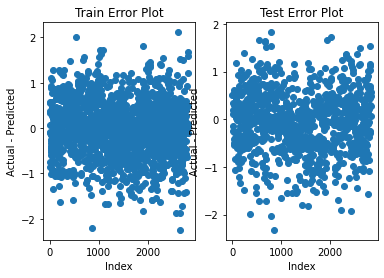

 50%|█████     | 1/2 [00:25<00:25, 25.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.0s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
SVR(C=4000, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.7710068392798112
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.8344908810222523


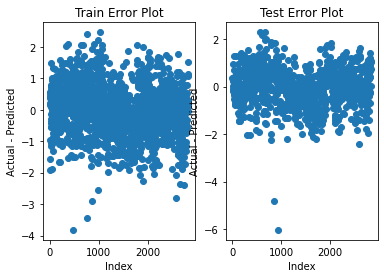

100%|██████████| 2/2 [00:39<00:00, 19.85s/it]


In [43]:
SVR_params = {'C':[500,600,700,900,1000,1500,2000,3000,4000]}
Poly_SVR = SVR(kernel='poly',degree=5,gamma="auto")

modelfunction(Poly_SVR,data,Y_train,Y_test,SVR_params)

### Sigmoid SVR

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.3s finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
SVR(C=80, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.6839160078089214
Root Mean squared Error Test for Avg Word2Vec Pos:  0.7008154167832686


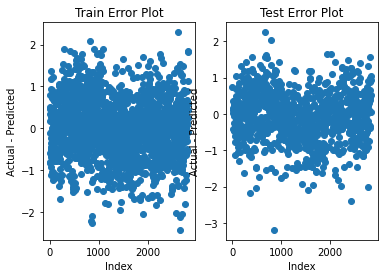

 50%|█████     | 1/2 [00:29<00:29, 29.25s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   15.3s finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
SVR(C=200, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.8253711053584694
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.8659691751287515


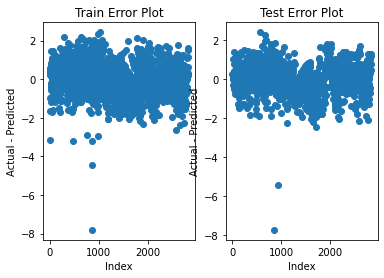

100%|██████████| 2/2 [00:46<00:00, 23.25s/it]


In [44]:
SVR_params = {'C':[80,100,150,200,300,400,500,600,700]}
Sig_SVR = SVR(kernel='sigmoid',gamma="auto")

modelfunction(Sig_SVR,data,Y_train,Y_test,SVR_params)

### Random Forest

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.0min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.26721956625501
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6964608280285508


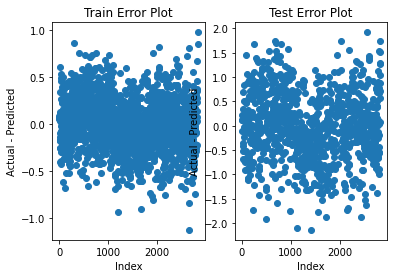

 50%|█████     | 1/2 [02:11<02:11, 131.50s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.0min finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.28619649761477745
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.7675640638249939


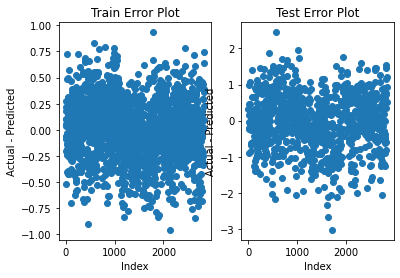

100%|██████████| 2/2 [04:23<00:00, 131.93s/it]


In [45]:
RF_params = {'n_estimators':[10,20,30,50,70,90,100]}

RandomForest = RandomForestRegressor()
modelfunction(RandomForest,data,Y_train,Y_test,RF_params)

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.1s finished


[10:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=180,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.395426634301687
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6465637550322151


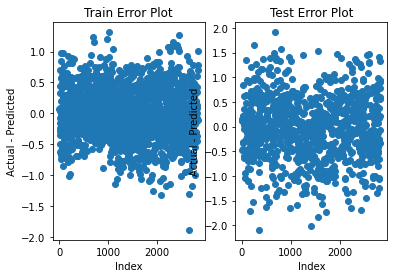

 50%|█████     | 1/2 [01:01<01:01, 61.65s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   59.5s finished


[10:45:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=140,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.4731398049214423
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.7527776295164736


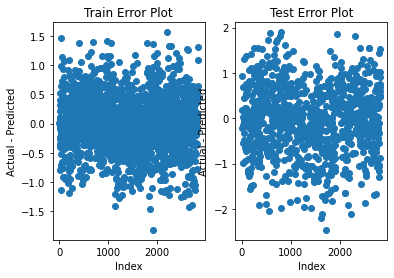

100%|██████████| 2/2 [02:03<00:00, 61.67s/it]


In [46]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

xgb = XGBRegressor()
modelfunction(xgb,data,Y_train,Y_test,xgb_params)

### Light GBM

  0%|          | 0/2 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.6min
[Paralle

----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=180, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.17044402713911858
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6526216652044162


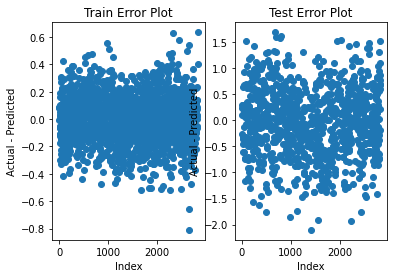

 50%|█████     | 1/2 [05:00<05:00, 300.41s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.5min
[Paralle

----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=180, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.197612968055684
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.7471688601622164


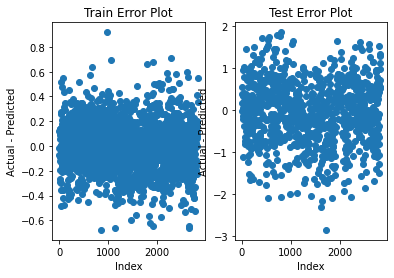

100%|██████████| 2/2 [09:57<00:00, 298.86s/it]


In [47]:
from lightgbm import LGBMRegressor

LGBM_params = {'boosting_type':['gbdt','dart','goss'],'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

lgbm = LGBMRegressor()
modelfunction(lgbm,data,Y_train,Y_test,LGBM_params)

### CAT Boost

     |████████████████████████████████| 69.2MB 60kB/s 


  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.8min finished


0:	learn: 1.0133038	total: 80.8ms	remaining: 14.5s
1:	learn: 0.9960355	total: 109ms	remaining: 9.7s
2:	learn: 0.9796089	total: 144ms	remaining: 8.48s
3:	learn: 0.9634033	total: 171ms	remaining: 7.53s
4:	learn: 0.9492304	total: 198ms	remaining: 6.94s
5:	learn: 0.9363645	total: 226ms	remaining: 6.55s
6:	learn: 0.9244846	total: 253ms	remaining: 6.26s
7:	learn: 0.9139214	total: 284ms	remaining: 6.11s
8:	learn: 0.9026898	total: 311ms	remaining: 5.92s
9:	learn: 0.8918536	total: 341ms	remaining: 5.79s
10:	learn: 0.8799900	total: 368ms	remaining: 5.66s
11:	learn: 0.8693870	total: 398ms	remaining: 5.57s
12:	learn: 0.8601640	total: 425ms	remaining: 5.45s
13:	learn: 0.8512898	total: 456ms	remaining: 5.41s
14:	learn: 0.8417627	total: 487ms	remaining: 5.35s
15:	learn: 0.8330003	total: 514ms	remaining: 5.27s
16:	learn: 0.8244237	total: 541ms	remaining: 5.19s
17:	learn: 0.8170747	total: 569ms	remaining: 5.12s
18:	learn: 0.8097284	total: 596ms	remaining: 5.05s
19:	learn: 0.8031605	total: 624ms	remaini

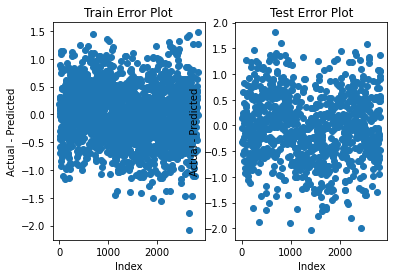

 50%|█████     | 1/2 [03:51<03:51, 231.01s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.7min finished


0:	learn: 1.0168523	total: 33.1ms	remaining: 5.92s
1:	learn: 1.0035126	total: 61.6ms	remaining: 5.49s
2:	learn: 0.9892417	total: 88.9ms	remaining: 5.25s
3:	learn: 0.9773897	total: 117ms	remaining: 5.14s
4:	learn: 0.9664069	total: 145ms	remaining: 5.06s
5:	learn: 0.9535130	total: 172ms	remaining: 5s
6:	learn: 0.9422242	total: 200ms	remaining: 4.94s
7:	learn: 0.9318259	total: 227ms	remaining: 4.89s
8:	learn: 0.9218615	total: 259ms	remaining: 4.93s
9:	learn: 0.9132127	total: 287ms	remaining: 4.88s
10:	learn: 0.9040117	total: 317ms	remaining: 4.86s
11:	learn: 0.8953370	total: 344ms	remaining: 4.81s
12:	learn: 0.8869775	total: 371ms	remaining: 4.77s
13:	learn: 0.8790679	total: 399ms	remaining: 4.73s
14:	learn: 0.8708451	total: 430ms	remaining: 4.72s
15:	learn: 0.8632779	total: 458ms	remaining: 4.7s
16:	learn: 0.8564564	total: 496ms	remaining: 4.75s
17:	learn: 0.8501498	total: 524ms	remaining: 4.71s
18:	learn: 0.8438162	total: 552ms	remaining: 4.67s
19:	learn: 0.8380310	total: 580ms	remainin

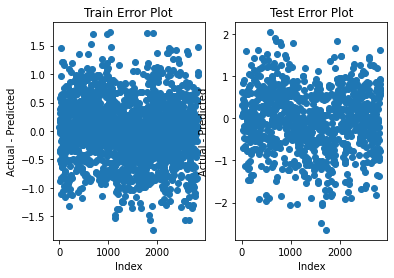

100%|██████████| 2/2 [07:39<00:00, 229.57s/it]


In [49]:
# !pip install catboost
from catboost import CatBoostRegressor

CATBoost_params = {'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

CB = CatBoostRegressor()
modelfunction(CB,data,Y_train,Y_test,CATBoost_params)

### Histogram Gradient Boosting Regressor

  0%|          | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   52.0s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.1min finished


----------------------------------------------------------------------------------------------------
The model is run on Avg Word2Vec Pos: 
HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.05,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=180, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
**************************************************
Root Mean squared Error Train for Avg Word2Vec Pos:  0.1717262398755842
Root Mean squared Error Test for Avg Word2Vec Pos:  0.6514989981320533


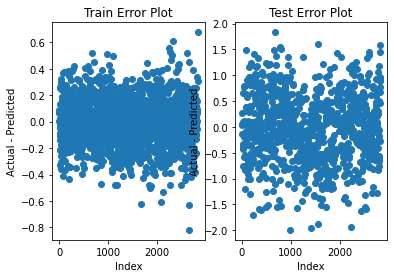

 50%|█████     | 1/2 [02:10<02:10, 130.07s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   49.9s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.0min finished


----------------------------------------------------------------------------------------------------
The model is run on TFIDF - Avg Word2Vec Pos: 
HistGradientBoostingRegressor(l2_regularization=0.0, learning_rate=0.05,
                              loss='least_squares', max_bins=255,
                              max_depth=None, max_iter=140, max_leaf_nodes=31,
                              min_samples_leaf=20, n_iter_no_change=None,
                              random_state=None, scoring=None, tol=1e-07,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False)
**************************************************
Root Mean squared Error Train for TFIDF - Avg Word2Vec Pos:  0.2571804478254936
Root Mean squared Error Test for TFIDF - Avg Word2Vec Pos:  0.7476013724943078


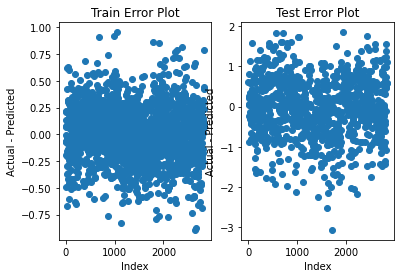

100%|██████████| 2/2 [04:14<00:00, 127.21s/it]


In [50]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

HistBoost_params = {'max_iter': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

HB = HistGradientBoostingRegressor()
modelfunction(HB,data,Y_train,Y_test,HistBoost_params)

### Combining all the Predicted Values into a Data Frame

In [ ]:
# # Saving the prediction value to a dataframe
# prediction_train = pd.DataFrame(Y_pred_train_Lasso, columns = ['Lasso'])
# prediction_test = pd.DataFrame(Y_pred_test_Lasso, columns = ['Lasso'])

# prediction_train['Ridge'] = Y_pred_train_Ridge
# prediction_test['Ridge'] = Y_pred_test_Ridge
# prediction_train['SGD'] = Y_pred_train_SGD
# prediction_test['SGD'] = Y_pred_test_SGD
# prediction_train['KNN'] = Y_pred_train_KNN
# prediction_test['KNN'] = Y_pred_test_KNN
# prediction_train['LinearSVR'] = Y_pred_train_LinearSVR
# prediction_test['LinearSVR'] = Y_pred_test_LinearSVR
# prediction_train['RBF_SVR'] = Y_pred_train_RBF_SVR
# prediction_test['RBF_SVR'] = Y_pred_test_RBF_SVR
# prediction_train['RandomForest'] = Y_pred_train_RandomForest
# prediction_test['RandomForest'] = Y_pred_test_RandomForest
# prediction_train['XGB'] = Y_pred_train_XGB
# prediction_test['XGB'] = Y_pred_test_XGB


# print(prediction_train.head(5))

### Stacking Regressor

In [ ]:
# Regressors
LR = Lasso(alpha=0.0001)
RR = Ridge(alpha=0.01)
SGD = SGDRegressor(alpha=0.000001, penalty='l1')
KNN = KNeighborsRegressor(algorithm='kd_tree', n_neighbors=30)
L_SVR = SVR(C=20,kernel='linear')
R_SVR = SVR(C=300, kernel='rbf')
RF = RandomForestRegressor(n_estimators=70)
XGB_R = XGBRegressor(learning_rate=0.1, n_estimators=180)

# Meta Classifier
SVR_RBF = SVR(kernel='rbf')
XGB_Meta = XGBRegressor()
lr_meta = LinearRegression()

Stack_Regress = StackingRegressor(regressors=[L_SVR,R_SVR,XGB_R,RF],meta_regressor=SVR_RBF)

Stack_Results = Stack_Regress.fit(X_train_excerpt_avg_w2v_pos, Y_train)

Y_pred_train = Stack_Results.predict(X_train_excerpt_avg_w2v_pos)
train_residuals = Y_train - Y_pred_train
Y_pred_test = Stack_Results.predict(X_test_excerpt_avg_w2v_pos)
test_residuals = Y_test - Y_pred_test
mse_train = metrics.mean_squared_error(Y_train,Y_pred_train)
mse_test = metrics.mean_squared_error(Y_test,Y_pred_test)

print("="*100)
print("Root Mean squared Error Train for Stacking Model", np.sqrt(mse_train))
print("Root Mean squared Error Test for Stacking Model", np.sqrt(mse_test))